### Importing necessary libraries

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Download datasets and Transform images

I get the FashionMINST image data from the source. Then I split 20% of train-set as validation-set. 
The batch size is 100 that means 100 samples per batch to load.

In [165]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST("./data", download = True, train = True, transform = transform)
testset = datasets.FashionMNIST("./data", download = True, train = False, transform = transform)

indexes = list(range(len(trainset)))
np.random.shuffle(indexes)
split_size = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indexes[:split_size])
valid_sample = SubsetRandomSampler(indexes[split_size:])

trainloader = DataLoader(trainset, sampler = train_sample, batch_size = 100)
validloader = DataLoader(trainset, sampler = valid_sample, batch_size = 100)
testloader = DataLoader(testset, batch_size = 100, shuffle = True)

### Visualize a Batch of Training Data

To see some images and their labels from train dataset I use matplotlib.

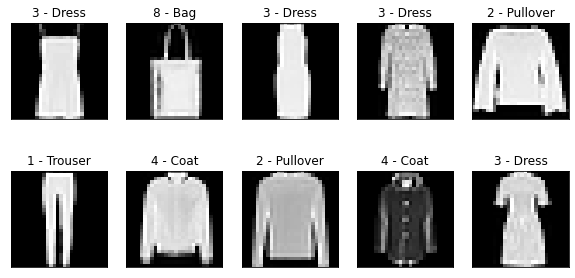

In [166]:
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
images, labels = iter(trainloader).next()
fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(np.squeeze(images[i]), cmap = 'gray')
    ax.set_title(str(labels[i].item())+' - '+label_names[labels[i].item()])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Define the Network Architecture, train the network and test the trained model

### Define the train and test methods

This method will train the model. Forward and backward phases are implemented. At the end, train loss and validation loss are printed for each epoch.

In [185]:
def MLP_train(n_epochs, model, optimizer, criterion, early_stopper = None):
  model.train()
  
  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    for data, target in validloader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    print('Epoch {} ---> Training Loss: {:.4f} \tValidation Loss: {:.4f}'.format(epoch + 1, train_loss, valid_loss))
    
    if(early_stopper):
      if early_stopper.early_stop(valid_loss): 
        print('Train stopped at epoch {}'.format(epoch+1))
        break


Test the traind model with test dataset and report the accuracy for each class and overall accuracy.

In [2]:
def MLP_test(model, criterion):
  model.eval()

  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  test_loss = 0.0
  for data, target in testloader:
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      pred = output.argmax(1)
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      for i in range(64):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(testloader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              str(i), 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
          
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

### Neural Network with one hidden layer

I start with a network that has one hidden layer. The input layer has 28 * 28 nuerons. becaus images have 28 * 28 pixels. I use ReLu as activation function and softmax for output layer.

In [213]:
class NueralNetwork(nn.Module):
    def __init__(self):
        super(NueralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

I train this simple model using:
30 epochs, SGD optimizer, learning rate = 0.01 and crossEntropy as loss function. You can see the result of training by train losses per epochs. 

In [225]:
n_epochs = 30
model = NueralNetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

MLP_train(n_epochs, model, optimizer, criterion)

Epoch 1 ---> Training Loss: 2.2625 	Validation Loss: 2.2089
Epoch 2 ---> Training Loss: 2.1102 	Validation Loss: 1.9683
Epoch 3 ---> Training Loss: 1.7661 	Validation Loss: 1.5655
Epoch 4 ---> Training Loss: 1.4079 	Validation Loss: 1.2786
Epoch 5 ---> Training Loss: 1.1782 	Validation Loss: 1.1047
Epoch 6 ---> Training Loss: 1.0355 	Validation Loss: 0.9965
Epoch 7 ---> Training Loss: 0.9427 	Validation Loss: 0.9195
Epoch 8 ---> Training Loss: 0.8777 	Validation Loss: 0.8684
Epoch 9 ---> Training Loss: 0.8300 	Validation Loss: 0.8225
Epoch 10 ---> Training Loss: 0.7922 	Validation Loss: 0.7905
Epoch 11 ---> Training Loss: 0.7599 	Validation Loss: 0.7655
Epoch 12 ---> Training Loss: 0.7337 	Validation Loss: 0.7408
Epoch 13 ---> Training Loss: 0.7110 	Validation Loss: 0.7188
Epoch 14 ---> Training Loss: 0.6902 	Validation Loss: 0.6996
Epoch 15 ---> Training Loss: 0.6718 	Validation Loss: 0.6811
Epoch 16 ---> Training Loss: 0.6537 	Validation Loss: 0.6709
Epoch 17 ---> Training Loss: 0.63

I reach 80% accuracy as a first try!

In [236]:
MLP_test(model, criterion)

Test Loss: 0.570205

Test Accuracy of     0: 81% (521/642)
Test Accuracy of     1: 94% (599/636)
Test Accuracy of     2: 56% (367/646)
Test Accuracy of     3: 85% (550/646)
Test Accuracy of     4: 88% (578/656)
Test Accuracy of     5: 88% (549/620)
Test Accuracy of     6: 29% (187/624)
Test Accuracy of     7: 90% (584/644)
Test Accuracy of     8: 93% (600/644)
Test Accuracy of     9: 92% (593/642)

Test Accuracy (Overall): 80% (5128/6400)


### Using dropout technique

In [237]:
class NueralNetwork1(nn.Module):
    def __init__(self):
        super(NueralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

In [238]:
model1 = NueralNetwork()
optimizer1 = optim.SGD(model1.parameters(), lr = 0.01)

MLP_train(n_epochs, model1, optimizer1, criterion)

Epoch 1 ---> Training Loss: 2.2563 	Validation Loss: 2.1940
Epoch 2 ---> Training Loss: 2.0742 	Validation Loss: 1.9173
Epoch 3 ---> Training Loss: 1.7206 	Validation Loss: 1.5370
Epoch 4 ---> Training Loss: 1.3862 	Validation Loss: 1.2666
Epoch 5 ---> Training Loss: 1.1648 	Validation Loss: 1.0931
Epoch 6 ---> Training Loss: 1.0233 	Validation Loss: 0.9846
Epoch 7 ---> Training Loss: 0.9299 	Validation Loss: 0.9111
Epoch 8 ---> Training Loss: 0.8670 	Validation Loss: 0.8560
Epoch 9 ---> Training Loss: 0.8215 	Validation Loss: 0.8211
Epoch 10 ---> Training Loss: 0.7860 	Validation Loss: 0.7899
Epoch 11 ---> Training Loss: 0.7584 	Validation Loss: 0.7624
Epoch 12 ---> Training Loss: 0.7347 	Validation Loss: 0.7445
Epoch 13 ---> Training Loss: 0.7142 	Validation Loss: 0.7200
Epoch 14 ---> Training Loss: 0.6941 	Validation Loss: 0.7070
Epoch 15 ---> Training Loss: 0.6765 	Validation Loss: 0.6941
Epoch 16 ---> Training Loss: 0.6594 	Validation Loss: 0.6752
Epoch 17 ---> Training Loss: 0.64

In [239]:
MLP_test(model1, criterion)

Test Loss: 0.553782

Test Accuracy of     0: 78% (499/636)
Test Accuracy of     1: 93% (620/660)
Test Accuracy of     2: 62% (404/649)
Test Accuracy of     3: 83% (512/614)
Test Accuracy of     4: 75% (495/655)
Test Accuracy of     5: 84% (529/627)
Test Accuracy of     6: 52% (322/618)
Test Accuracy of     7: 89% (573/643)
Test Accuracy of     8: 92% (598/648)
Test Accuracy of     9: 93% (609/650)

Test Accuracy (Overall): 80% (5161/6400)


*Using dropout technique didn't change the accuracy of this model.*

### Neural Network with two hidden layers

Add a hidden layer to the network and see the result.

In [240]:
class NueralNetwork2(nn.Module):
    def __init__(self):
        super(NueralNetwork2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x

In [243]:
model2 = NueralNetwork2()
optimizer2 = optim.SGD(model2.parameters(), lr = 0.01)

MLP_train(n_epochs, model2, optimizer2, criterion)

Epoch 1 ---> Training Loss: 2.2965 	Validation Loss: 2.2883
Epoch 2 ---> Training Loss: 2.2753 	Validation Loss: 2.2598
Epoch 3 ---> Training Loss: 2.2312 	Validation Loss: 2.1936
Epoch 4 ---> Training Loss: 2.1233 	Validation Loss: 2.0370
Epoch 5 ---> Training Loss: 1.9035 	Validation Loss: 1.7562
Epoch 6 ---> Training Loss: 1.6140 	Validation Loss: 1.5061
Epoch 7 ---> Training Loss: 1.4182 	Validation Loss: 1.3635
Epoch 8 ---> Training Loss: 1.3016 	Validation Loss: 1.2653
Epoch 9 ---> Training Loss: 1.2123 	Validation Loss: 1.1856
Epoch 10 ---> Training Loss: 1.1371 	Validation Loss: 1.1207
Epoch 11 ---> Training Loss: 1.0848 	Validation Loss: 1.0732
Epoch 12 ---> Training Loss: 1.0298 	Validation Loss: 1.0273
Epoch 13 ---> Training Loss: 0.9899 	Validation Loss: 0.9906
Epoch 14 ---> Training Loss: 0.9596 	Validation Loss: 0.9638
Epoch 15 ---> Training Loss: 0.9258 	Validation Loss: 0.9373
Epoch 16 ---> Training Loss: 0.9040 	Validation Loss: 0.9094
Epoch 17 ---> Training Loss: 0.87

In [244]:
MLP_test(model2, criterion)

Test Loss: 0.652566

Test Accuracy of     0: 82% (524/633)
Test Accuracy of     1: 94% (581/614)
Test Accuracy of     2: 63% (404/636)
Test Accuracy of     3: 82% (533/647)
Test Accuracy of     4: 72% (452/626)
Test Accuracy of     5: 76% (486/639)
Test Accuracy of     6: 14% (92/640)
Test Accuracy of     7: 87% (575/658)
Test Accuracy of     8: 91% (595/649)
Test Accuracy of     9: 95% (630/658)

Test Accuracy (Overall): 76% (4872/6400)


for this problem model with one hidden layer is better than two layer model.
adding layer increase the complexity of model that not required for this problem.

### Neural Network with three hidden layers

try three hidden layers model to see effect of adding another layer.

In [245]:
class NueralNetwork3(nn.Module):
    def __init__(self):
        super(NueralNetwork3, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim = 1)
        return x

In [246]:
model3 = NueralNetwork3()
optimizer3 = optim.SGD(model3.parameters(), lr = 0.01)

MLP_train(n_epochs, model3, optimizer3, criterion)

Epoch 1 ---> Training Loss: 2.3089 	Validation Loss: 2.3069
Epoch 2 ---> Training Loss: 2.3044 	Validation Loss: 2.3030
Epoch 3 ---> Training Loss: 2.3007 	Validation Loss: 2.2993
Epoch 4 ---> Training Loss: 2.2967 	Validation Loss: 2.2952
Epoch 5 ---> Training Loss: 2.2920 	Validation Loss: 2.2898
Epoch 6 ---> Training Loss: 2.2858 	Validation Loss: 2.2820
Epoch 7 ---> Training Loss: 2.2754 	Validation Loss: 2.2685
Epoch 8 ---> Training Loss: 2.2559 	Validation Loss: 2.2403
Epoch 9 ---> Training Loss: 2.2116 	Validation Loss: 2.1721
Epoch 10 ---> Training Loss: 2.1020 	Validation Loss: 2.0149
Epoch 11 ---> Training Loss: 1.9161 	Validation Loss: 1.8110
Epoch 12 ---> Training Loss: 1.7242 	Validation Loss: 1.6404
Epoch 13 ---> Training Loss: 1.5727 	Validation Loss: 1.5114
Epoch 14 ---> Training Loss: 1.4510 	Validation Loss: 1.4050
Epoch 15 ---> Training Loss: 1.3507 	Validation Loss: 1.3288
Epoch 16 ---> Training Loss: 1.2868 	Validation Loss: 1.2742
Epoch 17 ---> Training Loss: 1.23

In [247]:
MLP_test(model3, criterion)

Test Loss: 0.877245

Test Accuracy of     0: 77% (478/618)
Test Accuracy of     1: 91% (584/635)
Test Accuracy of     2: 71% (462/650)
Test Accuracy of     3: 62% (397/633)
Test Accuracy of     4: 36% (227/627)
Test Accuracy of     5: 38% (242/626)
Test Accuracy of     6:  8% (53/636)
Test Accuracy of     7: 84% (565/666)
Test Accuracy of     8: 91% (602/656)
Test Accuracy of     9: 93% (613/653)

Test Accuracy (Overall): 65% (4223/6400)


As I said adding layers would not help to improve the accuracy of the model in this problem.

### Using early stopping criteria

In [248]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [249]:
model = NueralNetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

early_stopper = EarlyStopper(patience = 2)
MLP_train(40, model, optimizer, criterion, early_stopper)

Epoch 1 ---> Training Loss: 2.2688 	Validation Loss: 2.2185
Epoch 2 ---> Training Loss: 2.1325 	Validation Loss: 2.0080
Epoch 3 ---> Training Loss: 1.8103 	Validation Loss: 1.5975
Epoch 4 ---> Training Loss: 1.4196 	Validation Loss: 1.2794
Epoch 5 ---> Training Loss: 1.1751 	Validation Loss: 1.0992
Epoch 6 ---> Training Loss: 1.0295 	Validation Loss: 0.9853
Epoch 7 ---> Training Loss: 0.9338 	Validation Loss: 0.9108
Epoch 8 ---> Training Loss: 0.8681 	Validation Loss: 0.8569
Epoch 9 ---> Training Loss: 0.8196 	Validation Loss: 0.8101
Epoch 10 ---> Training Loss: 0.7822 	Validation Loss: 0.7807
Epoch 11 ---> Training Loss: 0.7519 	Validation Loss: 0.7584
Epoch 12 ---> Training Loss: 0.7258 	Validation Loss: 0.7335
Epoch 13 ---> Training Loss: 0.7031 	Validation Loss: 0.7113
Epoch 14 ---> Training Loss: 0.6825 	Validation Loss: 0.6899
Epoch 15 ---> Training Loss: 0.6626 	Validation Loss: 0.6730
Epoch 16 ---> Training Loss: 0.6454 	Validation Loss: 0.6546
Epoch 17 ---> Training Loss: 0.62

In [250]:
MLP_test(model, criterion)

Test Loss: 0.510961

Test Accuracy of     0: 81% (518/635)
Test Accuracy of     1: 93% (588/627)
Test Accuracy of     2: 67% (434/645)
Test Accuracy of     3: 83% (530/637)
Test Accuracy of     4: 76% (493/648)
Test Accuracy of     5: 88% (595/673)
Test Accuracy of     6: 56% (360/639)
Test Accuracy of     7: 92% (577/624)
Test Accuracy of     8: 90% (575/633)
Test Accuracy of     9: 94% (605/639)

Test Accuracy (Overall): 82% (5275/6400)


### Using batch normalization

In [251]:
class NueralNetwork4(nn.Module):
    def __init__(self):
        super(NueralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

In [252]:
model4 = NueralNetwork()
optimizer4 = optim.SGD(model4.parameters(), lr = 0.01)

MLP_train(n_epochs, model4, optimizer4, criterion)

Epoch 1 ---> Training Loss: 2.2656 	Validation Loss: 2.2112
Epoch 2 ---> Training Loss: 2.1065 	Validation Loss: 1.9622
Epoch 3 ---> Training Loss: 1.7512 	Validation Loss: 1.5462
Epoch 4 ---> Training Loss: 1.3871 	Validation Loss: 1.2621
Epoch 5 ---> Training Loss: 1.1633 	Validation Loss: 1.0912
Epoch 6 ---> Training Loss: 1.0217 	Validation Loss: 0.9774
Epoch 7 ---> Training Loss: 0.9258 	Validation Loss: 0.9042
Epoch 8 ---> Training Loss: 0.8588 	Validation Loss: 0.8491
Epoch 9 ---> Training Loss: 0.8108 	Validation Loss: 0.8032
Epoch 10 ---> Training Loss: 0.7720 	Validation Loss: 0.7708
Epoch 11 ---> Training Loss: 0.7422 	Validation Loss: 0.7443
Epoch 12 ---> Training Loss: 0.7155 	Validation Loss: 0.7187
Epoch 13 ---> Training Loss: 0.6922 	Validation Loss: 0.6971
Epoch 14 ---> Training Loss: 0.6709 	Validation Loss: 0.6819
Epoch 15 ---> Training Loss: 0.6525 	Validation Loss: 0.6608
Epoch 16 ---> Training Loss: 0.6352 	Validation Loss: 0.6449
Epoch 17 ---> Training Loss: 0.61

In [ ]:
MLP_test(model4, criterion)

In [223]:
def MLP_train_regularized(n_epochs, model, optimizer, criterion, regular_type):
  model.train()
  
  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if(regular_type == 1):
          l1_lambda = 0.001
          l1_norm = sum(p.abs().sum() for p in model.parameters())
          loss = loss + l1_lambda * l1_norm
        elif(regular_type == 2):
          l2_lambda = 0.001
          l2_norm = sum(p.pow(2).sum() for p in model.parameters())
          loss = loss + l2_lambda * l2_norm
        elif(regular_type == 3):
          loss = loss + torch.norm(model.layer.weight, p = 2)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    for data, target in validloader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    print('Epoch {} ---> Training Loss: {:.4f} \tValidation Loss: {:.4f}'.format(epoch + 1, train_loss, valid_loss))

In [217]:
model = NueralNetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

MLP_train_regularized(n_epochs, model, optimizer, criterion, 1) #L1 regularization

Epoch 1 ---> Training Loss: 6.2779 	Validation Loss: 2.2212
Epoch 2 ---> Training Loss: 5.9184 	Validation Loss: 2.0578
Epoch 3 ---> Training Loss: 5.4486 	Validation Loss: 1.7280
Epoch 4 ---> Training Loss: 4.8911 	Validation Loss: 1.3999
Epoch 5 ---> Training Loss: 4.4306 	Validation Loss: 1.1963


In [218]:
MLP_test(model, criterion)

Test Loss: 1.202471

Test Accuracy of     0: 83% (531/639)
Test Accuracy of     1: 90% (581/639)
Test Accuracy of     2: 70% (465/657)
Test Accuracy of     3: 34% (219/635)
Test Accuracy of     4: 33% (215/650)
Test Accuracy of     5:  0% ( 6/619)
Test Accuracy of     6:  8% (52/640)
Test Accuracy of     7: 90% (591/656)
Test Accuracy of     8: 90% (579/637)
Test Accuracy of     9: 91% (576/628)

Test Accuracy (Overall): 59% (3815/6400)


In [219]:
model = NueralNetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

MLP_train_regularized(n_epochs, model, optimizer, criterion, 2) #L2 regularization

Epoch 1 ---> Training Loss: 6.2668 	Validation Loss: 2.2000
Epoch 2 ---> Training Loss: 5.8973 	Validation Loss: 2.0373
Epoch 3 ---> Training Loss: 5.4439 	Validation Loss: 1.7480
Epoch 4 ---> Training Loss: 4.9156 	Validation Loss: 1.4333
Epoch 5 ---> Training Loss: 4.4602 	Validation Loss: 1.2333


In [220]:
MLP_test(model, criterion)

Test Loss: 1.238327

Test Accuracy of     0: 81% (519/640)
Test Accuracy of     1: 90% (601/661)
Test Accuracy of     2: 15% (100/650)
Test Accuracy of     3: 36% (219/606)
Test Accuracy of     4: 82% (531/640)
Test Accuracy of     5:  0% ( 3/645)
Test Accuracy of     6:  3% (25/664)
Test Accuracy of     7: 92% (592/641)
Test Accuracy of     8: 81% (501/616)
Test Accuracy of     9: 89% (570/637)

Test Accuracy (Overall): 57% (3661/6400)


In [224]:
model = NueralNetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

MLP_train_regularized(n_epochs, model, optimizer, criterion, 3) #type 3 regularization

AttributeError: ignored